# References

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import constants
import os
from dotenv import load_dotenv
import scipy.io as sp
import pprint as pp
from scipy.signal import welch
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torch.nn.utils.rnn import pad_sequence

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=300, suppress=True)
pd.set_option('display.max_colwidth', 500)

# Constants

In [3]:
# some calculations
# for the dataset, 10 seconds = 1280 frames. 1 second = 128 frames. We can sue this to find the number of seconds that were taken to record the signature.

recording_samp_rate = 128 # per second
per_phase_frames = 1280 # seconds
max_seq_len_for_data = 3000 # frames
# desampling_factor = 1 # reducing sequences by this size

# Fetching raw data (Sign + EEG)

## Processing raw files

In [4]:
load_dotenv()
dataset_path = os.getenv('DATASET_PATH')

def get_dataset_files_and_user_ids(data_category, data_type = constants.TRAIN):
    user_ids = []
    labels = []
    files_mat = []
    
    # Get training and testing data
    data_split = pd.read_csv(os.path.join(dataset_path, "Identification_split.csv"))
    files_for_task = list(data_split[data_split.set == data_type].filename)
    data_categories = [constants.GENUINE, constants.FORGED] if data_category == constants.ALL else [data_category]

    for root, dirs, files in os.walk(dataset_path):
        if os.path.basename(root) in data_categories:
            for file in files:
                if file.endswith('.mat') and file in files_for_task:
                    files_mat.append(os.path.join(root, file))
                    labels.append(os.path.basename(root))
        if os.path.basename(root) != constants.GENUINE and os.path.basename(root) != constants.FORGED and os.path.basename(root) != 'SignEEGv1.0':
            user_ids.append(os.path.basename(root))
        
    return files_mat, user_ids, labels

In [ ]:
# small note: np.delete(axis = 1) will delete a column, axis = 0 will delete a row. be careful

## Getting list of sign data, eeg data and label for each file

In [5]:
def get_sig_eeg_raw_data(mat_files, labels, desampling_factor = 1):
    raw_data_list = []
    for mat_file, label in zip(mat_files, labels):
        mat_content = sp.loadmat(mat_file)
        user_id = str(mat_content['subject']['SubjectID'][0][0][0])
        sig_data = mat_content['subject']['SignWacom'][0][0]
        eeg_ica_data = mat_content['subject']['ICA_EEG'][0][0].T
        sig_data = torch.from_numpy(np.delete(sig_data, 0, axis=1)).to(dtype=torch.float32)
        
        # getting part of eeg data during which signature was recorded (ROI)
        roi_frames_start = -(eeg_ica_data.shape[0] % per_phase_frames) if per_phase_frames > 0 else 0
        eeg_ica_data = torch.from_numpy(eeg_ica_data[roi_frames_start:]).to(dtype=torch.float32)

        # desampling the data
        if desampling_factor > 1:
            sig_data = sig_data[::desampling_factor, :]
            eeg_ica_data = eeg_ica_data[::desampling_factor, :]

        if sig_data.shape[0] > max_seq_len_for_data:
            # print("Caught you!!!")
            # print("User ID: ", user_id)
            # print("File: ", mat_file)  
            continue # Skip these files because it's too long, outlier
        raw_data_list.append({
            'sign_data': sig_data,
            'eeg_data': eeg_ica_data,
            'user_id': user_id,
            'label': 0 if label == constants.GENUINE else 1,
            'file': mat_file
        })

    return raw_data_list


# Augmenting data

In [6]:
def augment_sign_data(sign_data, noise_std=0.01, scale_range=(0.95, 1.05), rotation_deg=5):
    augmented = sign_data.clone()
    augmented[:, 2:] += torch.randn_like(augmented[:, 2:]) * noise_std
    scale = random.uniform(*scale_range)
    augmented[:, 2] *= scale
    augmented[:, 3] *= scale

    # Random rotation (x, y)
    theta = math.radians(random.uniform(-rotation_deg, rotation_deg))
    x = augmented[:, 2].clone()
    y = augmented[:, 3].clone()
    augmented[:, 2] = x * math.cos(theta) - y * math.sin(theta)
    augmented[:, 3] = x * math.sin(theta) + y * math.cos(theta)

    return augmented

def augment_eeg_data(eeg_data, noise_std=0.01, scale_range=(0.95, 1.05), time_shift_max=10):
    augmented = eeg_data.clone()
    augmented += torch.randn_like(augmented) * noise_std
    scale = random.uniform(*scale_range)
    augmented *= scale
    shift = random.randint(-time_shift_max, time_shift_max)
    if shift > 0:
        augmented = torch.cat([augmented[shift:], torch.zeros_like(augmented[:shift])], dim=0)
    elif shift < 0:
        augmented = torch.cat([torch.zeros_like(augmented[shift:]), augmented[:shift]], dim=0)

    return augmented

# Sign Data Classification Process

## Sign data preprocessing

In [7]:
def normalize_sign_data_dict(sign_data):

    mean = torch.mean(sign_data[:, 2:], dim=0)
    std = torch.std(sign_data[:, 2:], dim=0)
    std = torch.where(std == 0, torch.tensor(1.0, dtype=torch.float32), std)
    normalized = (sign_data[:, 2:] - mean) / std
    normalized = torch.cat([sign_data[:, 0:2], normalized], dim=1).to(dtype=torch.float32)
    return normalized


## Sign Data Feature Extraction

In [8]:
def get_sign_data_features(sign_data):
    normalized_sign_data = normalize_sign_data_dict(sign_data)
    x = sign_data[:, 2]
    y = sign_data[:, 3]

    normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
    norm_x = normalized_sign_data[:, 2]
    norm_y = normalized_sign_data[:, 3]
    vx = torch.gradient(norm_x)[0]
    vy = torch.gradient(norm_y)[0]
    velocity = torch.sqrt(vx**2 + vy**2)
    ax = torch.gradient(vx)[0]
    ay = torch.gradient(vy)[0]
    acceleration = torch.sqrt(ax**2 + ay**2)
    
    avg_vx = torch.mean(vx)
    avg_vy = torch.mean(vy)
    avg_ax = torch.mean(ax)
    avg_ay = torch.mean(ay)
    
    # log curvature radius
    dt = 1
    dx = torch.gradient(norm_x, spacing=(dt,))[0]
    dy = torch.gradient(norm_y, spacing=(dt,))[0]
    v_t = torch.sqrt(dx ** 2 + dy ** 2)
    v_t = torch.where(v_t == 0, torch.tensor(1e-10, dtype=v_t.dtype), v_t)
    theta = torch.atan2(dy, dx)
    dtheta = torch.gradient(theta, spacing=(dt,))[0]
    dtheta = torch.where(dtheta == 0, torch.tensor(1e-10, dtype=dtheta.dtype), dtheta)
    log_curv_radius = torch.log(torch.abs(v_t / dtheta) + 1e-10)
    # print("Log Curve Radius shape: ", log_curv_radius.shape)
    # getting static features
    pendown_frames = normalized_sign_data[:, 1] == 1
    num_strokes = torch.unique(normalized_sign_data[pendown_frames][:, 0]).shape[0]
    x_down = normalized_sign_data[pendown_frames][:, 2]
    y_down = normalized_sign_data[pendown_frames][:, 3]
    sign_centroid = torch.tensor([torch.mean(x_down), torch.mean(y_down)], dtype=torch.float32)
    if y_down.shape[0] > 0:
        sign_height = torch.max(y_down) - torch.min(y_down)
    else:
        sign_height = 0
    if x_down.shape[0] > 0:
        sign_width = torch.max(x_down) - torch.min(x_down)
    else:
        sign_width = 0
    height_width_ratio = sign_height / sign_width if sign_width != 0 else torch.tensor(0.0, dtype=torch.float32)
    
    # new time dependent feature - jerk
    jerk = torch.sqrt(torch.gradient(vx)[0]**2 + torch.gradient(vy)[0]**2)

    pressure = sign_data[pendown_frames][:, 4]
    azimuth = sign_data[pendown_frames][:, 5]
    altitude = sign_data[pendown_frames][:, 6]
    avg_pressure = torch.mean(pressure)
    avg_azimuth = torch.mean(azimuth)
    avg_altitude = torch.mean(altitude)
    max_pressure = torch.max(pressure) if pressure.numel() > 0 else torch.tensor(0.0, dtype=torch.float32)
    sign_duration = sign_data.shape[0] / recording_samp_rate
    cls_token = torch.tensor([
        num_strokes, sign_height, sign_width, height_width_ratio, sign_centroid[0], sign_centroid[1], avg_pressure, avg_azimuth, avg_altitude, avg_vx, avg_vy, avg_ax, avg_ay, max_pressure, sign_duration], dtype=torch.float32)
    sign_data_aug = torch.cat([normalized_sign_data, velocity.unsqueeze(1), acceleration.unsqueeze(1), log_curv_radius.unsqueeze(1), jerk.unsqueeze(1)], dim=1)

    return sign_data_aug, cls_token

## Prepare sign dataset

In [9]:
def attach_attention_tokens_and_padding(data, max_len):
    # print("EEG Data shape: ", data.shape)
    if data.shape[0] == 0:
        feat_dim = data.shape[1] if data.ndim == 2 else 1
        return torch.zeros((max_len, feat_dim), dtype=torch.float32), torch.zeros(max_len, dtype=torch.float32)
    seq_len, feat_dim = data.shape
    pad_width = (0, max_len - seq_len)
    padded_data = torch.nn.functional.pad(data, (0, 0, 0, pad_width[1]), mode='constant', value=0)
    attention_mask = torch.zeros(max_len + 1, dtype=torch.float32)
    attention_mask[:seq_len + 1] = 1  # +1 for cls_token
    return padded_data, attention_mask


In [ ]:
# # For single data

# sign_dict_sample, eeg_dict_sample, label = get_sig_eeg_data_dicts([files_mat_appended[0]], [1])
# # print(sign_dict_sample['000000000200894'][0].shape)
# normalized_sign_data_sample = normalize_sign_data_dict(sign_dict_sample)
# sign_with_features = get_sign_data_features(normalized_sign_data_sample)
# # print()
# final_sign_data = sign_attach_attention_tokens_and_labels(sign_with_features, label)
# final_sign_dataset = prepare_sign_dataset_with_all_parts(final_sign_data)
# # print("Max len: ", get_sign_max_seq_len(sign_with_features))
# # print(final_sign_data)

## Sign Transformer

In [ ]:
# num_classes will be 2 (0 = unauthenticated, 1 = authenticated)

In [ ]:
''' current data format:

Just for reference, so that I don't forget later

original data: 

{
    user_id: string,
    data: [ [ [], [], [] ... ], [ [], [], [] ... ] ...  ], size: (30 * 1200 * 7) = (num_samples_per_user * time_series_len * num_features)
}

extracted data:

{
    cls_tokens: tensor([ , , , , ... ], [ , , , ,  ....], [ , , , , ...] ... ), size: (total_num_samples * num_features),
    data: tensor([ [], [], [] ... ], [ [], [], [] ... ] ...), size: (total_num_samples * time_series_len * num_features),
    attention_masks: tensor([1, 1, 1, ...], [1, 1,1, ...] ... ), size: (total_num_samples * time_series_len),
    labels: tensor([1, 0, 1, 0 ...]), size: (total_num_samples, )
}
'''

class SignatureDataset(Dataset):
    def __init__(self, input_data, num_classes):
        self.seq_len = input_data['sign_data'][0].shape[0]
        self.ts_dim = input_data['sign_data'][0].shape[1]
        self.num_classes = num_classes

        self.x_ts = input_data['sign_data']
        self.cls_token = input_data['sign_cls_tokens']
        self.labels = input_data['labels']
        self.attention_mask = input_data['sign_attention_masks']

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'x_ts': self.x_ts[idx],
            'cls_token': self.cls_token[idx],
            'labels': self.labels[idx],
            'attention_mask': self.attention_mask[idx]
        }


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len + 1, d_model)
        position = torch.arange(0, max_len + 1, dtype = torch.float).unsqueeze(1)
        divterm = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # Credits to hkproj@github for this as https://github.com/hkproj/pytorch-transformer/blob/main/model.py
        pe[:, 0::2] = torch.sin(position * divterm)
        pe[:, 1::2] = torch.cos(position * divterm)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return self.pe[:, :x.shape[1]]

In [ ]:
class SignatureTransformer(nn.Module):
    def __init__(self, input_dim, cls_dim, d_model, num_classes, num_heads, num_layers, max_seq_len, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)
        self.cls_proj = nn.Linear(cls_dim, d_model)
        self.input_projection = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dropout = dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        # uncomment for single modality
        self.classifier = nn.Sequential(nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, num_classes))

    def forward(self, x_ts, cls_token, attn_mask = None):
        x_ts = torch.nan_to_num(x_ts, nan=0.0, posinf=0.0, neginf=0.0)
        cls_token = torch.nan_to_num(cls_token, nan=0.0, posinf=0.0, neginf=0.0)
        batch_size, t, feat_dim = x_ts.shape
        x_proj = self.input_projection(x_ts)
        cls_proj = self.cls_proj(cls_token).unsqueeze(1)
        # print("x_proj size: ", x_proj.shape)
        # print("cls_proj size: ", cls_proj.shape)
        x = torch.cat([cls_proj, x_proj], dim=1)
        # print("x_proj and cls_proj concatenated size: ", x.shape)
        x = x + self.positional_encoding(x)

        if attn_mask is not None:
            attn_mask = attn_mask == 0 # True = ignore the value, False = include it!!!!!!!!!!
            # cls_mask = torch.zeros((batch_size, 1), dtype=torch.bool, device=attn_mask.device)
            full_mask = torch.cat([attn_mask], dim=1)  # [batch_size, t+1]
        else:
            full_mask = None
        # print("Mask shape: ", full_mask.shape)
        x = self.transformer(x, src_key_padding_mask=full_mask)
        cls_output = x[:, 0, :]
        # uncomment for single modality transformer
        # logits = self.classifier(cls_output)
        # return logits

        # uncomment for multimodal transformer
        return cls_output 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def sign_training_loop(model, dataloader, optimizer, loss_fn, device, num_epochs=10):

    model.to(device)
    model.train()
    model_path = os.getenv("MODEL_PATH")

    for epoch in range(num_epochs):
        total_loss = 0
        all_preds = []
        all_labels = []
        total_samples = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for i, batch in enumerate(tqdm(dataloader, desc="Training", leave=False)):
            x_ts = batch['x_ts'].to(device)
            cls_token = batch['cls_token'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            optimizer.zero_grad()
            logits = model(x_ts, cls_token, attention_mask)
            loss = loss_fn(logits, labels)

            if torch.isnan(loss):
                print("NaN loss detected!")
                print("Labels:", labels)
                print("Logits:", logits)
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item() * x_ts.size(0)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += x_ts.size(0)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, zero_division=0)
        rec = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        print(f"Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    torch.save(model.state_dict(), os.path.join(model_path, f"model{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

## Sign Data Feed to Transformer

In [ ]:
input_data = {
    'sign_data': sign_data,
    'eeg_data': eeg_data,
    'sign_attention_masks': sign_attention_masks,
    'eeg_attention_masks': eeg_attention_masks,
    'sign_cls_tokens': sign_cls_tokens,
    'eeg_cls_tokens': eeg_cls_tokens,
    'labels': labels,
}
ts_dim = input_data['sign_data'][0].size(1)
cls_dim = input_data['sign_cls_tokens'][0].size(0)
d_model = 64
num_classes = 2
seq_len = max([data.shape[0] for data in input_data['sign_data']])
batch_size = 8

dataset = SignatureDataset(input_data, num_classes)
# dataset.__getitem__(0)['x_ts'].shape
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sign_model = SignatureTransformer(input_dim=ts_dim, cls_dim=cls_dim, d_model=d_model, num_classes=num_classes, num_heads=4, num_layers=2, max_seq_len=seq_len)
optimizer = optim.Adam(sign_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sign_training_loop(sign_model, dataloader, optimizer, loss_fn, device, num_epochs=10)

## Sign - Misc

In [ ]:
# # print(len(final_signature_data['002108410100044']['cls_tokens']))
# # print(len(final_signature_data['002108410100044']['data']))
# # print(len(final_signature_data['002108410100044']['attention_masks']))

# # print(final_signature_data['002108410100044']['cls_tokens'][0].shape)
# # print(final_signature_data['002108410100044']['data'][0].shape)
# # print(final_signature_data['002108410100044']['attention_masks'][0].shape)


# print(len(final_sign_dataset_for_all_users['cls_tokens']))
# print(len(final_sign_dataset_for_all_users['data']))
# print(len(final_sign_dataset_for_all_users['attention_masks']))
# print(len(final_sign_dataset_for_all_users['labels']))

In [ ]:


# print(len(final_sign_dataset_for_all_users['cls_tokens']))
# print(len(final_sign_dataset_for_all_users['data']))
# print(len(final_sign_dataset_for_all_users['attention_masks']))

# print(final_sign_dataset_for_all_users['cls_tokens'][0].shape)
# print(final_sign_dataset_for_all_users['data'][0].shape)
# print(final_sign_dataset_for_all_users['attention_masks'][0].shape)

In [ ]:
# print(normalized_sign_data_dict['000000000200894'][0].shape)

In [ ]:
# normalized_sign_data_dict = normalize_sign_data_dict(sign_data_dict)
# # print(sign_data_dict['000000000200894'])

In [ ]:
# print(len(sign_times_for_users))


# EEG Data Classification Process

## EEG Data Preprocessing

In [11]:
def normalize_eeg_data_dict(eeg_data_dict):
    normalized_eeg_data_dict = {}
    for user_id, eeg_list in eeg_data_dict.items():
        normalized_eeg_data_dict[user_id] = []
        for eeg_data in eeg_list:
            mean = eeg_data.mean(dim=0, keepdim=True)
            std = eeg_data.std(dim=0, keepdim=True)
            std = torch.where(std == 0, torch.tensor(1.0, dtype=std.dtype, device=std.device), std)
            normalized = (eeg_data - mean) / std
            normalized_eeg_data_dict[user_id].append(normalized)
    return normalized_eeg_data_dict

## EEG Feature Extraction

In [12]:
def extract_fft_features(eeg_data, fs=128, epoch_length_sec=1): # taking 1s instead of 30s because the signal duration is short
    n_samples, n_channels = eeg_data.shape
    epoch_len = int(epoch_length_sec * fs)
    n_epochs = n_samples // epoch_len
    features = []
    for i in range(n_epochs):
        epoch = eeg_data[i*epoch_len:(i+1)*epoch_len, :]
        epoch_features = []
        for ch in range(n_channels):
            fft_vals = np.fft.rfft(epoch[:, ch])
            fft_power = np.abs(fft_vals)
            epoch_features.extend(np.abs(fft_vals).flatten())
        features.append(epoch_features)
    return features

In [13]:
def get_nth_difference_mean_for_signal(input_signal, n):
    input_signal = torch.as_tensor(input_signal)
    diff = torch.abs(input_signal[n:] - input_signal[:-n])
    res = torch.sum(diff) / (input_signal.shape[0] - n)
    return res

def normalize_for_eeg_related_data(data):
    data = torch.as_tensor(data, dtype=torch.float32)
    mean = torch.mean(data, dim=0)
    std = torch.std(data, dim=0)
    std = torch.where(std == 0, torch.tensor(1.0, dtype=std.dtype, device=std.device), std)
    norm = (data - mean) / std
    return norm

def get_eeg_data_features(eeg_data, fs=recording_samp_rate):

    signal_mean = torch.mean(eeg_data)
    signal_std = torch.std(eeg_data)

    first_difference_sample_mean_absolute_difference_raw_signal = get_nth_difference_mean_for_signal(eeg_data, 1)
    second_difference_sample_mean_absolute_difference_raw_signal = get_nth_difference_mean_for_signal(eeg_data, 2)

    normalized_signal = normalize_for_eeg_related_data(eeg_data)
    first_difference_sample_mean_absolute_difference_normalized_signal = get_nth_difference_mean_for_signal(normalized_signal, 1)
    second_difference_sample_mean_absolute_difference_normalized_signal = get_nth_difference_mean_for_signal(normalized_signal, 2)
    fw_powers = []
    eeg_data = torch.as_tensor(eeg_data, dtype=torch.float32)
    for ch in range(normalized_signal.shape[1]):
        # Welch returns numpy arrays, so convert to torch
        f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
        f = torch.from_numpy(f).to(normalized_signal.device)
        Pxx = torch.from_numpy(Pxx).to(normalized_signal.device)
        fw_power = torch.sum(f * Pxx) / torch.sum(Pxx) if torch.sum(Pxx) > 0 else torch.tensor(0.0, device=normalized_signal.device)
        fw_powers.append(fw_power)
    fw_power_arr = torch.stack(fw_powers).unsqueeze(0)
    # cls_token = torch.cat([signal_mean, signal_std, first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal, first_difference_sample_mean_absolute_difference_normalized_signal, second_difference_sample_mean_absolute_difference_normalized_signal])
    # cls_token = torch.stack(fw_power_arr)
    fft_features = extract_fft_features(normalized_signal.cpu().numpy(), fs=fs) # because we are using np.fft.rfft
    features = [signal_mean, signal_std, first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal, first_difference_sample_mean_absolute_difference_normalized_signal, second_difference_sample_mean_absolute_difference_normalized_signal]
    # for epoch_feat in fft_features:
    #     features.extend(epoch_feat)
    features.extend(fw_power_arr.squeeze(0).tolist())
    cls_token = torch.tensor(features, dtype=torch.float32)
    # uncomment if fft_features as eeg_data fails
    # return normalized_signal, cls_token
    fft_features = torch.tensor(fft_features, dtype=torch.float32)
    fft_features = torch.nan_to_num(fft_features, nan=0.0, posinf=0.0, neginf=0.0)
    return normalized_signal, fft_features, cls_token

## EEG Classification

In [ ]:
# # All EEG Data

# files_mat_genuine, user_ids_genuine, genuine_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE)
# files_mat_forged, user_ids_forged, forged_labels = get_dataset_files_and_user_ids(data_category=constants.FORGED)

# files_mat_genuine.extend(files_mat_forged)
# files_mat_appended = files_mat_genuine
# genuine_labels.extend(forged_labels)
# labels_appended = genuine_labels

# # shuffling to prevent overfitting
# files_all = np.array(files_mat_appended)
# labels_all = np.array(labels_appended)

# indices = np.arange(len(files_all))
# np.random.shuffle(indices)

# files_mat_appended = files_all[indices]
# labels_appended = labels_all[indices]

# sign_data_dict, eeg_data_dict, labels = get_sig_eeg_raw_data(files_mat_appended, labels_appended)
# normalized_eeg_data_dict = normalize_eeg_data_dict(eeg_data_dict)
# eeg_data_with_features = get_eeg_data_features(normalized_eeg_data_dict)
# eeg_final_data = eeg_attach_attention_tokens_and_labels(eeg_data_with_features, labels)
# eeg_final_dataset = prepare_eeg_dataset_with_all_parts(eeg_final_data)

In [ ]:
# input_data = eeg_final_dataset
# ts_dim = input_data['data'][0].size(1)
# cls_dim = input_data['cls_tokens'][0].size(0)
# d_model = 64
# num_classes = 2
# seq_len = get_eeg_max_seq_len(eeg_data_with_features)
# batch_size = 8

# dataset = SignatureDataset(input_data, num_classes)
# # dataset.__getitem__(0)['x_ts'].shape
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# eeg_model = SignatureTransformer(input_dim=ts_dim, cls_dim=cls_dim, d_model=d_model, num_classes=num_classes, num_heads=4, num_layers=4, max_seq_len=seq_len)
# optimizer = optim.Adam(eeg_model.parameters(), lr=1e-4)
# loss_fn = nn.CrossEntropyLoss()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sign_training_loop(eeg_model, dataloader, optimizer, loss_fn, device, num_epochs=10)

# Sign + EEG Classification

## Getting the EEG and Sign data

In [ ]:
files_mat_genuine, user_ids_genuine, genuine_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE)
files_mat_forged, user_ids_forged, forged_labels = get_dataset_files_and_user_ids(data_category=constants.FORGED)

files_mat_genuine.extend(files_mat_forged)
files_mat_appended = files_mat_genuine
genuine_labels.extend(forged_labels)
labels_appended = genuine_labels

# shuffling to prevent overfitting
files_all = np.array(files_mat_appended)
labels_all = np.array(labels_appended)

indices = np.arange(len(files_all))
np.random.shuffle(indices)

files_mat_appended = files_all[indices]
labels_appended = labels_all[indices]

raw_data = get_sig_eeg_raw_data(files_mat_appended, labels_appended)

# for debugging only
print("EEG Data seq len: ", [data['eeg_data'].shape[0] for data in raw_data])

augmented_raw_data = []
num_augments = 3

for sample in raw_data:
    augmented_raw_data.append(sample)
    for _ in range(num_augments):
        aug_sample = sample.copy()
        aug_sample['sign_data'] = augment_sign_data(sample['sign_data'])
        aug_sample['eeg_data'] = augment_eeg_data(sample['eeg_data'])
        augmented_raw_data.append(aug_sample)

raw_data = augmented_raw_data

for i in range(len(raw_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_data[i]['sign_data'])
    eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_data[i]['eeg_data'])
    # print("EEG Feature data shape: ", eeg_data_with_features.shape)
    raw_data[i]['sign_data'] = sign_data_with_features
    raw_data[i]['sign_cls_token'] = sign_cls_token
    raw_data[i]['eeg_data'] = eeg_data_with_features
    raw_data[i]['eeg_cls_token'] = eeg_cls_token

# sign_max_seq_len = max([data['sign_data'].shape[0] for data in raw_data])
# eeg_max_seq_len = max([data['eeg_data'].shape[0] for data in raw_data])

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = 10

for i in range(len(raw_data)):
    sign_data = raw_data[i]['sign_data']
    eeg_data = raw_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_data[i]['sign_data'] = sign_data
    raw_data[i]['eeg_data'] = eeg_data
    raw_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_data[i]['eeg_attention_mask'] = eeg_attention_mask

sign_data = [data['sign_data'] for data in raw_data]
eeg_data = [data['eeg_data'] for data in raw_data]
sign_attention_masks = [data['sign_attention_mask'] for data in raw_data]
eeg_attention_masks = [data['eeg_attention_mask'] for data in raw_data]
sign_cls_tokens = [data['sign_cls_token'] for data in raw_data]
eeg_cls_tokens = [data['eeg_cls_token'] for data in raw_data]
labels = [data['label'] for data in raw_data]
files = [data['file'] for data in raw_data]

In [ ]:
print("Sign data type: ", type(sign_data))
print("EEG data type: ", type(eeg_data))
print("Sign attention mask type: ", type(sign_attention_masks[0]))
print("EEG attention mask type: ", type(eeg_attention_masks[0]))
print("Sign cls token type: ", type(sign_cls_tokens[0]))
print("EEG cls token type: ", type(eeg_cls_tokens[0]))
print("Labels type: ", type(labels))
print("Files type: ", type(files))


print("Sign data shape: ", sign_data[0].shape)
print("EEG data shape: ", eeg_data[0].shape)
print("Sign attention mask shape: ", sign_attention_masks[0].shape)
print("EEG attention mask shape: ", eeg_attention_masks[0].shape)
print("Sign cls token shape: ", sign_cls_tokens[0].shape)
print("EEG cls token shape: ", eeg_cls_tokens[0].shape)
print("Labels shape: ", len(labels))
print("Files shape: ", len(files))

## Redesigning the Transformer model implementation

In [ ]:
class SignatureEEGDataset(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        sign_attention_masks = input_data['sign_attention_masks']
        eeg_attention_masks = input_data['eeg_attention_masks']
        sign_cls_tokens = input_data['sign_cls_tokens']
        eeg_cls_tokens = input_data['eeg_cls_tokens']
        labels = input_data['labels']

        self.sign_x_ts = sign_data
        self.sign_cls_token = sign_cls_tokens
        self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = eeg_data
        self.eeg_cls_token = eeg_cls_tokens
        self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]

        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            'sign_cls_token': self.sign_cls_token[idx],
            'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            'eeg_cls_token': self.eeg_cls_token[idx],
            'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len + 1, d_model)
        position = torch.arange(0, max_len + 1, dtype = torch.float).unsqueeze(1)
        divterm = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # Credits to hkproj@github for this as https://github.com/hkproj/pytorch-transformer/blob/main/model.py
        pe[:, 0::2] = torch.sin(position * divterm)
        pe[:, 1::2] = torch.cos(position * divterm)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return self.pe[:, :x.shape[1]]

In [ ]:
class SignatureEEGTransformer(nn.Module):
    def __init__(self, sign_input_dim, sign_cls_dim, eeg_input_dim, eeg_cls_dim, d_model, num_classes, num_heads, num_layers, sign_max_seq_len, eeg_max_seq_len, dropout = 0.1):
        super().__init__()
        self.sign_transfomer = SignatureTransformer(sign_input_dim, sign_cls_dim, d_model, num_classes, num_heads, num_layers, sign_max_seq_len, dropout)
        self.eeg_transformer = SignatureTransformer(eeg_input_dim, eeg_cls_dim, d_model, num_classes, num_heads, num_layers, eeg_max_seq_len, dropout)

        self.classifier = nn.Sequential(nn.Linear(d_model * 2, d_model), nn.ReLU(), nn.Linear(d_model, num_classes))

    def forward(self, sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attn_mask = None, eeg_attn_mask = None):
        sign_cls = self.sign_transfomer(sign_x_ts, sign_cls_token, sign_attn_mask)
        eeg_cls = self.eeg_transformer(eeg_x_ts, eeg_cls_token, eeg_attn_mask)
        multimodal_cls_output = torch.cat([sign_cls, eeg_cls], dim = 1)

        logits = self.classifier(multimodal_cls_output)
        return logits

In [ ]:
input_data = {
    'sign_data': sign_data,
    'eeg_data': eeg_data,
    'sign_attention_masks': sign_attention_masks,
    'eeg_attention_masks': eeg_attention_masks,
    'sign_cls_tokens': sign_cls_tokens,
    'eeg_cls_tokens': eeg_cls_tokens,
    'labels': labels,
}
num_classes = 2
multimodal_dataset = SignatureEEGDataset(input_data, num_classes)
batch_size = 16
multimodal_dataloader = DataLoader(multimodal_dataset, batch_size=batch_size, shuffle=True)
sign_ts_dim = input_data['sign_data'][0].size(1)
sign_cls_dim = input_data['sign_cls_tokens'][0].size(0)
sign_seq_len = input_data['sign_data'][0].size(0)
eeg_ts_dim = input_data['eeg_data'][0].size(1)
eeg_cls_dim = input_data['eeg_cls_tokens'][0].size(0)
eeg_seq_len = input_data['eeg_data'][0].size(0)


In [ ]:
# transformer training loop
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = SignatureEEGTransformer(sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim, eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim, d_model=128, num_classes=2, num_heads=4, num_layers=2, sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# loss_fn = nn.CrossEntropyLoss()
# num_epochs = 5

labels_np = labels.cpu().numpy() if isinstance(labels, torch.Tensor) and labels.is_cuda else (
    labels.numpy() if isinstance(labels, torch.Tensor) else labels
)

train_indices, val_indices = train_test_split(
    range(len(labels)), test_size=0.2, random_state=42, stratify=labels
)
train_data = [raw_data[i] for i in train_indices]
val_data = [raw_data[i] for i in val_indices]

def build_input(data):
    return {
        'sign_data': [d['sign_data'] for d in data],
        'eeg_data': [d['eeg_data'] for d in data],
        'sign_attention_masks': [d['sign_attention_mask'] for d in data],
        'eeg_attention_masks': [d['eeg_attention_mask'] for d in data],
        'sign_cls_tokens': [d['sign_cls_token'] for d in data],
        'eeg_cls_tokens': [d['eeg_cls_token'] for d in data],
        'labels': [d['label'] for d in data],
    }

train_input = build_input(train_data)
val_input = build_input(val_data)

train_dataset = SignatureEEGDataset(train_input, num_classes=2)
val_dataset = SignatureEEGDataset(val_input, num_classes=2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=128, num_classes=2, num_heads=4, num_layers=2,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, train_labels, train_preds = 0, [], []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())

    avg_train_loss = train_loss / len(train_labels)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss, val_labels, val_preds = 0, [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_labels)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("="*50)
torch.save(model.state_dict(), os.path.join(os.getenv("MODEL_PATH"), f"multimodal_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

In [ ]:
# validation loop
# Set model to evaluation mode

# Prepare test data
files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)
raw_test_data = get_sig_eeg_raw_data(files_mat_test, test_labels)

# Augment and preprocess test data (no augmentation, just features and padding)
for i in range(len(raw_test_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
    eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
    raw_test_data[i]['sign_data'] = sign_data_with_features
    raw_test_data[i]['sign_cls_token'] = sign_cls_token
    raw_test_data[i]['eeg_data'] = eeg_data_with_features
    raw_test_data[i]['eeg_cls_token'] = eeg_cls_token

sign_max_seq_len_test = max_seq_len_for_data
eeg_max_seq_len_test = 10

for i in range(len(raw_test_data)):
    sign_data = raw_test_data[i]['sign_data']
    eeg_data = raw_test_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len_test)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len_test)
    raw_test_data[i]['sign_data'] = sign_data
    raw_test_data[i]['eeg_data'] = eeg_data
    raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

test_input_data = {
    'sign_data': [data['sign_data'] for data in raw_test_data],
    'eeg_data': [data['eeg_data'] for data in raw_test_data],
    'sign_attention_masks': [data['sign_attention_mask'] for data in raw_test_data],
    'eeg_attention_masks': [data['eeg_attention_mask'] for data in raw_test_data],
    'sign_cls_tokens': [data['sign_cls_token'] for data in raw_test_data],
    'eeg_cls_tokens': [data['eeg_cls_token'] for data in raw_test_data],
    'labels': [data['label'] for data in raw_test_data],
}

sign_ts_dim = test_input_data['sign_data'][0].size(1)
sign_cls_dim = test_input_data['sign_cls_tokens'][0].size(0)
sign_seq_len = test_input_data['sign_data'][0].size(0)
eeg_ts_dim = test_input_data['eeg_data'][0].size(1)
eeg_cls_dim = test_input_data['eeg_cls_tokens'][0].size(0)
eeg_seq_len = test_input_data['eeg_data'][0].size(0)

model.eval()

In [ ]:
model.eval()
val_loss = 0
val_labels = []
val_preds = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        val_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

avg_val_loss = val_loss / len(val_labels)
val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds, zero_division=0)
val_rec = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Sign + EEG anomaly detection - Transformer

In [69]:
class AnomalyDataset(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        sign_attention_masks = input_data['sign_attention_masks']
        eeg_attention_masks = input_data['eeg_attention_masks']
        # sign_cls_tokens = input_data['sign_cls_tokens']
        # eeg_cls_tokens = input_data['eeg_cls_tokens']
        labels = input_data['labels']

        self.sign_x_ts = sign_data
        # self.sign_cls_token = sign_cls_tokens
        self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = eeg_data
        # self.eeg_cls_token = eeg_cls_tokens
        self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]

        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            # 'sign_cls_token': self.sign_cls_token[idx],
            'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            # 'eeg_cls_token': self.eeg_cls_token[idx],
            'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [14]:

files_mat_genuine_train, user_ids_genuine_train, train_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.TRAIN)
files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)

raw_data_train = get_sig_eeg_raw_data(files_mat_genuine_train, train_labels)
raw_data_test = get_sig_eeg_raw_data(files_mat_test, test_labels)

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = int(max_seq_len_for_data // 2)

for i in range(len(raw_data_train)):
    sign_feat, _ = get_sign_data_features(raw_data_train[i]['sign_data'])
    eeg_data, _, _ = get_eeg_data_features(raw_data_train[i]['eeg_data'])
    sign_feat, sign_mask = attach_attention_tokens_and_padding(sign_feat, sign_max_seq_len)
    eeg_data, eeg_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_data_train[i]['sign_data'] = sign_feat
    raw_data_train[i]['eeg_data'] = eeg_data
    raw_data_train[i]['sign_attention_mask'] = sign_mask
    raw_data_train[i]['eeg_attention_mask'] = eeg_mask

for i in range(len(raw_data_test)):
    sign_feat, _ = get_sign_data_features(raw_data_test[i]['sign_data'])
    eeg_data, _, _ = get_eeg_data_features(raw_data_test[i]['eeg_data'])
    sign_feat, sign_mask = attach_attention_tokens_and_padding(sign_feat, sign_max_seq_len)
    eeg_data, eeg_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_data_test[i]['sign_data'] = sign_feat
    raw_data_test[i]['eeg_data'] = eeg_data
    raw_data_test[i]['sign_attention_mask'] = sign_mask
    raw_data_test[i]['eeg_attention_mask'] = eeg_mask

sign_data_train = [d['sign_data'] for d in raw_data_train]
eeg_data_train = [d['eeg_data'] for d in raw_data_train]
sign_attention_masks_train = [d['sign_attention_mask'][1:] for d in raw_data_train]
eeg_attention_masks_train = [d['eeg_attention_mask'][1:] for d in raw_data_train]
labels_train = [d['label'] for d in raw_data_train]

sign_data_test = [d['sign_data'] for d in raw_data_test]
eeg_data_test = [d['eeg_data'] for d in raw_data_test]
sign_attention_masks_test = [d['sign_attention_mask'][1:] for d in raw_data_test]
eeg_attention_masks_test = [d['eeg_attention_mask'][1:] for d in raw_data_test]
labels_test = [d['label'] for d in raw_data_test]

C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\2339106861.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nper

In [15]:
input_data_train = {
    'sign_data': sign_data_train,
    'eeg_data': eeg_data_train,
    'sign_attention_masks': sign_attention_masks_train,
    'eeg_attention_masks': eeg_attention_masks_train,
    'labels': labels_train,
}
input_data_test = {
    'sign_data': sign_data_test,
    'eeg_data': eeg_data_test,
    'sign_attention_masks': sign_attention_masks_test,
    'eeg_attention_masks': eeg_attention_masks_test,
    'labels': labels_test,
}
anomaly_train_dataset = AnomalyDataset(input_data_train, num_classes=1)
anomaly_test_dataset = AnomalyDataset(input_data_test, num_classes=1)
anomaly_train_loader = DataLoader(anomaly_train_dataset, batch_size=16, shuffle=True)
anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)
sign_ts_dim_train = input_data_train['sign_data'][0].size(1)
# sign_attention_masks_train = input_data_train['sign_attention_masks'][0].size(0)
sign_seq_len_train = input_data_train['sign_data'][0].size(0)
eeg_ts_dim_train = input_data_train['eeg_data'][0].size(1)
# eeg_attention_masks_train = input_data_train['eeg_attention_masks'][0].size(0)
eeg_seq_len_train = input_data_train['eeg_data'][0].size(0)

sign_ts_dim_test = input_data_test['sign_data'][0].size(1)
# sign_attention_masks_test = input_data_test['sign_attention_masks'][0].size(0)
sign_seq_len_test = input_data_test['sign_data'][0].size(0)
eeg_ts_dim_test = input_data_test['eeg_data'][0].size(1)
# eeg_attention_masks_test = input_data_test['eeg_attention_masks'][0].size(0)
eeg_seq_len_test = input_data_test['eeg_data'][0].size(0)


NameError: name 'AnomalyDataset' is not defined

In [72]:
# print("Sign data type: ", eeg_data_train[0])
# print("EEG data type: ", type(eeg_data))
# print("Sign attention mask type: ", type(sign_attention_masks[0]))
# print("EEG attention mask type: ", type(eeg_attention_masks[0]))
# print("Sign cls token type: ", type(sign_cls_tokens[0]))
# print("EEG cls token type: ", type(eeg_cls_tokens[0]))
# print("Labels type: ", type(labels))
# print("Files type: ", type(files))


print("Sign data shape: ", sign_data_train[0].shape)
print("EEG data shape: ", eeg_data_train[0].shape)
print("Sign attention mask shape: ", sign_attention_masks_train[0].shape)
print("EEG attention mask shape: ", eeg_attention_masks_train[0].shape)
# print("Sign cls token shape: ", sign_cls_tokens_train[0].shape)
# print("EEG cls token shape: ", eeg_cls_tokens_train[0].shape)
print("Labels shape: ", len(labels_train))
print("Labels unique elements: ", set(labels_train))
# print("Files shape: ", len(files_train))

Sign data shape:  torch.Size([3000, 11])
EEG data shape:  torch.Size([1500, 5])
Sign attention mask shape:  torch.Size([3000])
EEG attention mask shape:  torch.Size([1500])
Labels shape:  582
Labels unique elements:  {0}


In [ ]:
# print(torch.isnan(sign_x_ts).any(), torch.isinf(sign_x_ts).any())
# print(torch.isnan(eeg_x_ts).any(), torch.isinf(eeg_x_ts).any())

In [73]:
class SignEEGTransformerAutoEncoder(nn.Module):
    def __init__(self, sign_input_dim, sign_seq_len, eeg_input_dim, eeg_seq_len, d_model=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.sign_input_proj = nn.Linear(sign_input_dim, d_model)
        self.sign_pos_enc = PositionalEncoding(d_model, sign_seq_len)
        sign_encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.sign_encoder = nn.TransformerEncoder(sign_encoder_layer, num_layers=num_layers)
        sign_decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.sign_decoder = nn.TransformerDecoder(sign_decoder_layer, num_layers=num_layers)
        self.sign_output_proj = nn.Linear(d_model, sign_input_dim)

        self.eeg_input_proj = nn.Linear(eeg_input_dim, d_model)
        self.eeg_pos_enc = PositionalEncoding(d_model, eeg_seq_len)
        eeg_encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.eeg_encoder = nn.TransformerEncoder(eeg_encoder_layer, num_layers=num_layers)
        eeg_decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.eeg_decoder = nn.TransformerDecoder(eeg_decoder_layer, num_layers=num_layers)
        self.eeg_output_proj = nn.Linear(d_model, eeg_input_dim)

    def forward(self, sign_x, eeg_x, sign_attn_mask=None, eeg_attn_mask=None):
        sign_x_proj = self.sign_input_proj(sign_x) + self.sign_pos_enc(sign_x)
        sign_memory = self.sign_encoder(sign_x_proj, src_key_padding_mask=sign_attn_mask)
        sign_decoded = self.sign_decoder(sign_x_proj, sign_memory, tgt_key_padding_mask=sign_attn_mask, memory_key_padding_mask=sign_attn_mask)
        sign_recon = self.sign_output_proj(sign_decoded)
        eeg_x_proj = self.eeg_input_proj(eeg_x) + self.eeg_pos_enc(eeg_x)
        eeg_memory = self.eeg_encoder(eeg_x_proj, src_key_padding_mask=eeg_attn_mask)
        eeg_decoded = self.eeg_decoder(eeg_x_proj, eeg_memory, tgt_key_padding_mask=eeg_attn_mask, memory_key_padding_mask=eeg_attn_mask)
        eeg_recon = self.eeg_output_proj(eeg_decoded)

        return sign_recon, eeg_recon

In [ ]:
def train_validate_autoencoder(model, train_loader, val_loader, device, num_epochs=20, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            sign_x = batch['sign_x_ts'].to(device)
            sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
            if sign_mask.dim() == 3:
                sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None
            eeg_x = batch['eeg_x_ts'].to(device)
            eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
            if eeg_mask.dim() == 3:
                eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

            optimizer.zero_grad()
            sign_recon, eeg_recon = model(sign_x, eeg_x, sign_mask, eeg_mask)
            loss_sign = loss_fn(sign_recon, sign_x)
            loss_eeg = loss_fn(eeg_recon, eeg_x)
            loss = loss_sign + loss_eeg
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                sign_x = batch['sign_x_ts'].to(device)
                sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
                if sign_mask.dim() == 3:
                    sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None 
                eeg_x = batch['eeg_x_ts'].to(device)
                eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
                if eeg_mask.dim() == 3:
                    eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

                sign_recon, eeg_recon = model(sign_x, eeg_x, sign_mask, eeg_mask)
                loss_sign = loss_fn(sign_recon, sign_x)
                loss_eeg = loss_fn(eeg_recon, eeg_x)
                loss = loss_sign + loss_eeg
                val_loss += loss.item() 
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")
    return model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
anomaly_model = SignEEGTransformerAutoEncoder(sign_input_dim=sign_ts_dim_train, sign_seq_len=sign_seq_len_train, eeg_input_dim=eeg_ts_dim_train, eeg_seq_len=eeg_seq_len_train, d_model=128, num_heads=4, num_layers=2).to(device)

model = train_validate_autoencoder(anomaly_model, anomaly_train_loader, anomaly_test_loader, device, num_epochs=10, lr=1e-5)

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_8784\991432957.py:10: SyntaxWarning: invalid escape sequence '\m'
  model.load_state_dict(torch.load("D:\\KCL Final Year Individual Project\\Implementation\\Project Implementation\models\\anomaly_model_07212025-153342.pth", map_location='cpu'))
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_8784\991432957.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)


ROC AUC: 0.5362
Accuracy: 0.5778
Precision: 0.6800
Recall: 0.1910
F1 Score: 0.2982
              precision    recall  f1-score   support

     Genuine       0.56      0.92      0.70       201
     Anomaly       0.68      0.19      0.30       178

    accuracy                           0.58       379
   macro avg       0.62      0.56      0.50       379
weighted avg       0.62      0.58      0.51       379

Confusion Matrix:
 [[185  16]
 [144  34]]


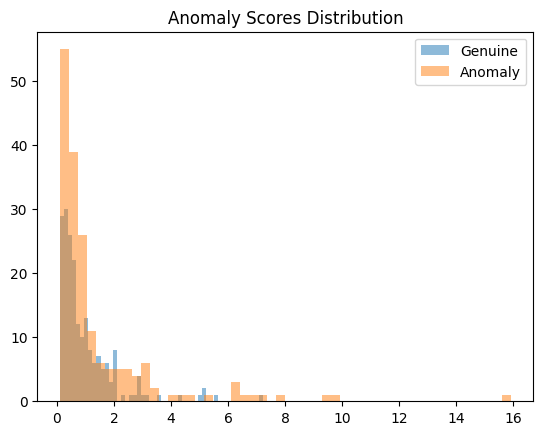

In [ ]:
# model = SignEEGTransformerAutoEncoder(
#     sign_input_dim=sign_ts_dim_test,
#     sign_seq_len=sign_seq_len_test,
#     eeg_input_dim=eeg_ts_dim_test,
#     eeg_seq_len=eeg_seq_len_test,
#     d_model=128,
#     num_heads=4,
#     num_layers=2
# )
# model.load_state_dict(torch.load("D:\\KCL Final Year Individual Project\\Implementation\\Project Implementation\models\\anomaly_model_07212025-153342.pth", map_location='cpu'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

model.to(device)
model.eval()
all_scores = []
all_labels = []

with torch.no_grad():
    for batch in anomaly_test_loader:
        sign_x_ts = batch['sign_x_ts'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)
        sign_recon, eeg_recon = model(sign_x_ts, eeg_x_ts, sign_attention_mask, eeg_attention_mask)
        sign_error = ((sign_recon - sign_x_ts) ** 2).max(dim=(1, 2)).cpu().numpy()
        eeg_error = ((eeg_recon - eeg_x_ts) ** 2).max(dim=(1, 2)).cpu().numpy()
        scores = sign_error + eeg_error
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy())

all_scores_np = np.array(all_scores)
all_labels_np = np.array(all_labels)
fpr, tpr, thresholds = roc_curve(all_labels_np, all_scores_np)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
# print("Optimal threshold:", optimal_threshold)
preds = (np.array(all_scores) > threshold).astype(int)
roc = roc_auc_score(all_labels, all_scores)
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds, zero_division=0)
f1 = f1_score(all_labels, preds, zero_division=0)

print(f"ROC AUC: {roc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels=[0,1]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=50, alpha=0.5, label='Genuine')
plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=50, alpha=0.5, label='Anomaly')
plt.legend()
plt.title("Anomaly Scores Distribution")
plt.show()

## Sign + EEG Anomaly - CNN

In [38]:
class AnomalyCNNDataset(Dataset):
    def __init__(self, input_data):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        labels = input_data['labels']

        self.sign_x_ts = sign_data
        # # self.sign_cls_token = sign_cls_tokens
        # self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = eeg_data
        # # self.eeg_cls_token = eeg_cls_tokens
        # self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]

        # self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            # # 'sign_cls_token': self.sign_cls_token[idx],
            # 'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            # # 'eeg_cls_token': self.eeg_cls_token[idx],
            # 'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [17]:
class CNNEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, latent_dim, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.encoder(x)
        return z.squeeze(-1) 

In [18]:
class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * (seq_len // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (32, seq_len // 4)),
            nn.ConvTranspose1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, output_dim, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, z):
        x = self.decoder(z)
        return x.permute(0, 2, 1)

In [46]:
class SignEEGCNNAutoencoder(nn.Module):
    def __init__(self, sign_input_dim, eeg_input_dim, sign_seq_len, eeg_seq_len, latent_dim=32):
        super().__init__()
        self.sign_encoder = CNNEncoder(sign_input_dim, latent_dim)
        self.eeg_encoder = CNNEncoder(eeg_input_dim, latent_dim)
        self.sign_decoder = CNNDecoder(latent_dim, sign_input_dim, sign_seq_len)
        self.eeg_decoder = CNNDecoder(latent_dim, eeg_input_dim, eeg_seq_len)

    def forward(self, sign_x, eeg_x):
        sign_z = self.sign_encoder(sign_x)
        eeg_z = self.eeg_encoder(eeg_x)
        sign_recon = self.sign_decoder(sign_z)
        eeg_recon = self.eeg_decoder(eeg_z)
        return sign_recon, eeg_recon

In [58]:
def train_validate_autoencoder(model, train_loader, device, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            # print("Current batch sign seq len: ", batch['sign_x_ts'].shape[1])
            # print("Current batch eeg seq len: ", batch['eeg_x_ts'].shape[1])
            sign_x = batch['sign_x_ts'].to(device)
            # sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
            # if sign_mask.dim() == 3:
            #     sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None
            eeg_x = batch['eeg_x_ts'].to(device)
            # eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
            # if eeg_mask.dim() == 3:
            #     eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

            optimizer.zero_grad()
            sign_recon, eeg_recon = model(sign_x, eeg_x)
            loss_sign = loss_fn(sign_recon, sign_x)
            loss_eeg = loss_fn(eeg_recon, eeg_x)
            loss = loss_sign + loss_eeg
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

        # model.eval()
        # val_loss = 0
        # with torch.no_grad():
        #     for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
        #         sign_x = batch['sign_x_ts'].to(device)
        #         # sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
        #         # if sign_mask.dim() == 3:
        #         #     sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None 
        #         eeg_x = batch['eeg_x_ts'].to(device)
        #         # eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
        #         # if eeg_mask.dim() == 3:
        #         #     eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

        #         sign_recon, eeg_recon = model(sign_x, eeg_x)
        #         loss_sign = loss_fn(sign_recon, sign_x)
        #         loss_eeg = loss_fn(eeg_recon, eeg_x)
        #         loss = loss_sign + loss_eeg
        #         val_loss += loss.item() 
        # avg_val_loss = val_loss / len(val_loader.dataset)
        # print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")
    return model

In [ ]:
files_mat_genuine_train, user_ids_genuine_train, train_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.TRAIN)
files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)

raw_data_train = get_sig_eeg_raw_data(files_mat_genuine_train, train_labels)
raw_data_test = get_sig_eeg_raw_data(files_mat_test, test_labels)

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = int(max_seq_len_for_data // 2)

for i in range(len(raw_data_train)):
    sign_feat, sign_cls_token = get_sign_data_features(raw_data_train[i]['sign_data'])
    eeg_data, eeg_features, eeg_cls_token = get_eeg_data_features(raw_data_train[i]['eeg_data'])
    sign_cls_expanded = sign_cls_token.unsqueeze(0).expand(sign_data.shape[0], -1)
    sign_data = torch.cat((sign_feat, sign_cls_expanded), dim=1)
    eeg_cls_expanded = eeg_cls_token.unsqueeze(0).expand(eeg_data.shape[0], -1)
    eeg_data = torch.cat([eeg_data, eeg_cls_expanded], dim=1)
    raw_data_train[i]['sign_data'] = sign_feat
    raw_data_train[i]['eeg_data'] = eeg_data

for i in range(len(raw_data_test)):
    sign_feat, _ = get_sign_data_features(raw_data_test[i]['sign_data'])
    eeg_data, _, _ = get_eeg_data_features(raw_data_test[i]['eeg_data'])
    raw_data_test[i]['sign_data'] = sign_feat
    raw_data_test[i]['eeg_data'] = eeg_data

sign_data_train = [d['sign_data'] for d in raw_data_train]
eeg_data_train = [d['eeg_data'] for d in raw_data_train]
labels_train = [d['label'] for d in raw_data_train]

sign_data_test = [d['sign_data'] for d in raw_data_test]
eeg_data_test = [d['eeg_data'] for d in raw_data_test]
labels_test = [d['label'] for d in raw_data_test]

C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\2339106861.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_2588\4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nper

In [55]:
def sign_eeg_collate_fn(batch):
    # Use your global fixed lengths
    fixed_sign_len = max_seq_len_for_data
    fixed_eeg_len = int(max_seq_len_for_data // 2)
    sign_x = [item['sign_x_ts'] for item in batch]
    eeg_x = [item['eeg_x_ts'] for item in batch]
    labels = [item['labels'] for item in batch]
    # Pad each sample individually to fixed length
    sign_x_padded = torch.stack([
        torch.nn.functional.pad(x, (0, 0, 0, fixed_sign_len - x.shape[0]), mode='constant', value=0)
        for x in sign_x
    ])
    eeg_x_padded = torch.stack([
        torch.nn.functional.pad(x, (0, 0, 0, fixed_eeg_len - x.shape[0]), mode='constant', value=0)
        for x in eeg_x
    ])
    labels = torch.tensor(labels, dtype=torch.long)
    return {
        'sign_x_ts': sign_x_padded,
        'eeg_x_ts': eeg_x_padded,
        'labels': labels
    }

In [49]:
input_data_train = {
    'sign_data': sign_data_train,
    'eeg_data': eeg_data_train,
    # 'sign_attention_masks': sign_attention_masks_train,
    # 'eeg_attention_masks': eeg_attention_masks_train,
    'labels': labels_train,
}
input_data_test = {
    'sign_data': sign_data_test,
    'eeg_data': eeg_data_test,
    # 'sign_attention_masks': sign_attention_masks_test,
    # 'eeg_attention_masks': eeg_attention_masks_test,
    'labels': labels_test,
}
# anomaly_train_dataset = AnomalyCNNDataset(input_data_train)
# anomaly_test_dataset = AnomalyCNNDataset(input_data_test)
# anomaly_train_loader = DataLoader(anomaly_train_dataset, batch_size=16, shuffle=True, collate_fn=sign_collate_fn)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False, collate_fn=eeg_collate_fn)
sign_ts_dim_train = input_data_train['sign_data'][0].size(1)
# sign_attention_masks_train = input_data_train['sign_attention_masks'][0].size(0)
sign_seq_len_train = input_data_train['sign_data'][0].size(0)
eeg_ts_dim_train = input_data_train['eeg_data'][0].size(1)
# eeg_attention_masks_train = input_data_train['eeg_attention_masks'][0].size(0)
eeg_seq_len_train = input_data_train['eeg_data'][0].size(0)

sign_ts_dim_test = input_data_test['sign_data'][0].size(1)
# sign_attention_masks_test = input_data_test['sign_attention_masks'][0].size(0)
sign_seq_len_test = input_data_test['sign_data'][0].size(0)
eeg_ts_dim_test = input_data_test['eeg_data'][0].size(1)
# eeg_attention_masks_test = input_data_test['eeg_attention_masks'][0].size(0)
eeg_seq_len_test = input_data_test['eeg_data'][0].size(0)

In [59]:
sign_seq_len = sign_data_train[0].shape[0]
sign_input_dim = sign_data_train[0].shape[1]
eeg_seq_len = eeg_data_train[0].shape[0]
eeg_input_dim = eeg_data_train[0].shape[1]
latent_dim = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = AnomalyCNNDataset(input_data_train)
test_dataset = AnomalyCNNDataset(input_data_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=sign_eeg_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=sign_eeg_collate_fn)

anomaly_cnn_model = SignEEGCNNAutoencoder(sign_input_dim, eeg_input_dim, max_seq_len_for_data, int(max_seq_len_for_data // 2), latent_dim).to(device)
anomaly_model = train_validate_autoencoder(anomaly_cnn_model, train_loader, device=device, num_epochs=10, lr=1e-4)

Epoch 1 Training:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.2395


Epoch 2 | Train Loss: 0.2337


Epoch 3 | Train Loss: 0.2110


Epoch 4 | Train Loss: 0.1701


Epoch 5 | Train Loss: 0.1566


Epoch 6 | Train Loss: 0.1531


Epoch 7 | Train Loss: 0.1528


Epoch 8 | Train Loss: 0.1507


Epoch 9 | Train Loss: 0.1500


Epoch 10 | Train Loss: 0.1489


In [62]:
anomaly_model.eval()
all_scores = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        sign_x = batch['sign_x_ts'].to(device)
        eeg_x = batch['eeg_x_ts'].to(device)
        labels = batch['labels'].cpu().numpy()
        sign_recon, eeg_recon = anomaly_model(sign_x, eeg_x)
        # using max squared error per sample as anomaly score
        sign_error = torch.amax((sign_recon - sign_x) ** 2, dim=(1, 2)).cpu().numpy()
        eeg_error = torch.amax((eeg_recon - eeg_x) ** 2, dim=(1, 2)).cpu().numpy()
        scores = sign_error + eeg_error
        all_scores.extend(scores)
        all_labels.extend(labels)

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

Testing: 100%|██████████| 24/24 [00:00<00:00, 25.05it/s]


ROC AUC: 0.5732
Accuracy: 0.5805
Precision: 0.5888
Recall: 0.3539
F1 Score: 0.4421
              precision    recall  f1-score   support

     Genuine       0.58      0.78      0.66       201
     Anomaly       0.59      0.35      0.44       178

    accuracy                           0.58       379
   macro avg       0.58      0.57      0.55       379
weighted avg       0.58      0.58      0.56       379

Confusion Matrix:
 [[157  44]
 [115  63]]


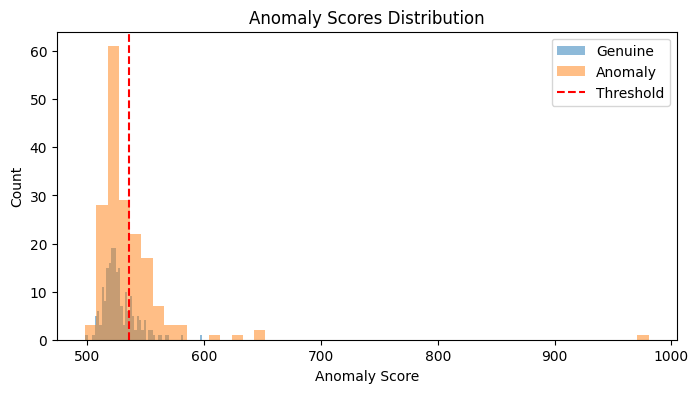

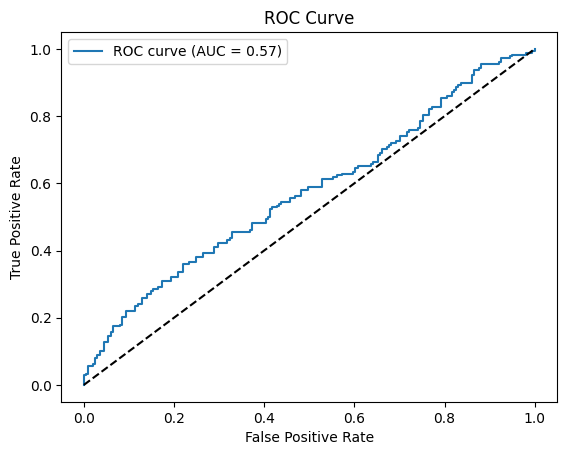

In [65]:
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
preds = (all_scores > threshold).astype(int)

acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds, zero_division=0)
f1 = f1_score(all_labels, preds, zero_division=0)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels=[0,1]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

plt.figure(figsize=(8, 4))
plt.hist(all_scores[all_labels==0], bins=50, alpha=0.5, label='Genuine')
plt.hist(all_scores[all_labels==1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Anomaly Scores Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Anomaly Misc

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# num_epochs = 10

# anomaly_model = SignatureEEGTransformer(
#     sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
#     eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
#     d_model=128, num_classes=1, num_heads=4, num_layers=4,
#     sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
# ).to(device)

# optimizer = torch.optim.Adam(anomaly_model.parameters(), lr=1e-5)
# loss_fn = nn.BCEWithLogitsLoss() # only one class, so only one logit output per sample

# anomaly_test_dataset = SignatureEEGDataset(test_input_data, num_classes=1)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

# for epoch in range(num_epochs):
#     anomaly_model.train()
#     total_loss = 0
#     for batch in tqdm(anomaly_train_dataloader, desc=f"Epoch {epoch+1} Training", leave=False):
#         sign_x_ts = batch['sign_x_ts'].to(device)
#         sign_cls_token = batch['sign_cls_token'].to(device)
#         sign_attention_mask = batch['sign_attention_mask'].to(device)
#         eeg_x_ts = batch['eeg_x_ts'].to(device)
#         eeg_cls_token = batch['eeg_cls_token'].to(device)
#         eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#         labels = torch.zeros(sign_x_ts.size(0), dtype=torch.float32).to(device)  # All genuine = 0

#         optimizer.zero_grad()
#         logits = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#         loss = loss_fn(logits.squeeze(1), labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(anomaly_model.parameters(), max_norm=1.0)
#         optimizer.step()
#         total_loss += loss.item() * labels.size(0)
#     avg_loss = total_loss / len(anomaly_train_dataloader.dataset)
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

#     threshold = 0.5 
#     # Validation/Test at every epoch
#     anomaly_model.eval()
#     all_scores = []
#     all_labels = []
#     with torch.no_grad():
#         for batch in anomaly_test_loader:
#             sign_x_ts = batch['sign_x_ts'].to(device)
#             sign_cls_token = batch['sign_cls_token'].to(device)
#             sign_attention_mask = batch['sign_attention_mask'].to(device)
#             eeg_x_ts = batch['eeg_x_ts'].to(device)
#             eeg_cls_token = batch['eeg_cls_token'].to(device)
#             eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#             labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)
#             scores = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#             all_scores.extend(scores.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#     preds = (np.array(all_scores) > threshold).astype(int)
#     roc = roc_auc_score(all_labels, all_scores)
#     print(f"Validation ROC AUC: {roc:.4f}")
#     print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels=[0,1]))
#     print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))
#     plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=50, alpha=0.5, label='Genuine')
#     plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=50, alpha=0.5, label='Anomaly')
#     plt.legend()
#     plt.show()

In [ ]:
# # training loop for anomaly detection
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# num_epochs = 5

# anomaly_model = SignatureEEGTransformer(
#     sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
#     eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
#     d_model=128, num_classes=1, num_heads=4, num_layers=2,
#     sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
# ).to(device)

# optimizer = torch.optim.Adam(anomaly_model.parameters(), lr=1e-5)
# loss_fn = nn.BCEWithLogitsLoss() # only one class, so only one logit output per sample

# anomaly_model.train()
# for epoch in range(num_epochs):
#     total_loss = 0
#     for batch in tqdm(anomaly_train_dataloader, desc=f"Epoch {epoch+1} Training", leave=False):
#         sign_x_ts = batch['sign_x_ts'].to(device)
#         sign_cls_token = batch['sign_cls_token'].to(device)
#         sign_attention_mask = batch['sign_attention_mask'].to(device)
#         eeg_x_ts = batch['eeg_x_ts'].to(device)
#         eeg_cls_token = batch['eeg_cls_token'].to(device)
#         eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#         labels = torch.zeros(sign_x_ts.size(0), dtype=torch.float32).to(device)  # All genuine = 0

#         optimizer.zero_grad()
#         logits = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#         loss = loss_fn(logits.squeeze(1), labels) # logits size turned out to be [8,1] so we need to squeeze it to [8]
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(anomaly_model.parameters(), max_norm=1.0)
#         optimizer.step()
#         total_loss += loss.item() * labels.size(0)
#     avg_loss = total_loss / len(anomaly_train_dataloader.dataset)
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")


In [ ]:
torch.save(anomaly_model.state_dict(), os.path.join(os.getenv("MODEL_PATH"), f"anomaly_detection_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

In [ ]:

# # testing loop for anomaly detection
# files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)
# raw_test_data = get_sig_eeg_raw_data(files_mat_test, test_labels)

# # Augment and preprocess test data (no augmentation, just features and padding)
# for i in range(len(raw_test_data)):
#     _, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
#     _, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
#     # raw_test_data[i]['sign_data'] = sign_data_with_features
#     raw_test_data[i]['sign_cls_token'] = sign_cls_token
#     # raw_test_data[i]['eeg_data'] = eeg_data_with_features
#     raw_test_data[i]['eeg_cls_token'] = eeg_cls_token

# sign_max_seq_len_test = int(max_seq_len_for_data//2)
# eeg_max_seq_len_test = int(max_seq_len_for_data // 4)

# for i in range(len(raw_test_data)):
#     sign_data = raw_test_data[i]['sign_data']
#     eeg_data = raw_test_data[i]['eeg_data']
#     sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len_test)
#     eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len_test)
#     raw_test_data[i]['sign_data'] = sign_data
#     raw_test_data[i]['eeg_data'] = eeg_data
#     raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
#     raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

# test_input_data = {
#     'sign_data': [data['sign_data'] for data in raw_test_data],
#     'eeg_data': [data['eeg_data'] for data in raw_test_data],
#     'sign_attention_masks': [data['sign_attention_mask'] for data in raw_test_data],
#     'eeg_attention_masks': [data['eeg_attention_mask'] for data in raw_test_data],
#     'sign_cls_tokens': [data['sign_cls_token'] for data in raw_test_data],
#     'eeg_cls_tokens': [data['eeg_cls_token'] for data in raw_test_data],
#     'labels': [data['label'] for data in raw_test_data],
# }

# sign_ts_dim = test_input_data['sign_data'][0].size(1)
# sign_cls_dim = test_input_data['sign_cls_tokens'][0].size(0)
# sign_seq_len = test_input_data['sign_data'][0].size(0)
# eeg_ts_dim = test_input_data['eeg_data'][0].size(1)
# eeg_cls_dim = test_input_data['eeg_cls_tokens'][0].size(0)
# eeg_seq_len = test_input_data['eeg_data'][0].size(0)

In [ ]:
# anomaly_test_dataset = SignatureEEGDataset(test_input_data, num_classes=1)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

In [ ]:
# threshold = 0.5
# anomaly_test_dataset = SignatureEEGDataset(test_input_data, num_classes=1)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

# anomaly_model.eval()
# all_scores = []
# all_labels = []
# with torch.no_grad():
#     for batch in tqdm(anomaly_test_loader, desc="Testing", leave=False):
#         sign_x_ts = batch['sign_x_ts'].to(device)
#         sign_cls_token = batch['sign_cls_token'].to(device)
#         sign_attention_mask = batch['sign_attention_mask'].to(device)
#         eeg_x_ts = batch['eeg_x_ts'].to(device)
#         eeg_cls_token = batch['eeg_cls_token'].to(device)
#         eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#         labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)
#         scores = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#         all_scores.extend(scores.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
# preds = (np.array(all_scores) > threshold).astype(int)
# print("ROC AUC:", roc_auc_score(all_labels, all_scores))
# print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels = [0,1]))
# print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

In [ ]:
# pp.pprint(list(zip(all_scores, all_labels, preds)))

In [ ]:
# plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=50, alpha=0.5, label='Genuine')
# plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=50, alpha=0.5, label='Anomaly')
# plt.legend()
# plt.show()

# Sign + EEG in CNN

In [ ]:
class SignatureEEGDatasetForCNN(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        labels = input_data['labels']

        self.sign_x_ts = sign_data

        self.eeg_x_ts = eeg_data

        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            'labels': self.labels[idx],
        }

In [ ]:
# def prepare_sign_eeg_for_cnn(input_data):
#     sign_data = input_data['sign_data']
#     eeg_data = input_data['eeg_data']
#     sign_cls_tokens = input_data['sign_cls_tokens']
#     eeg_cls_tokens = input_data['eeg_cls_tokens']
#     labels = input_data['labels']

#     sign_cnn_data = []
#     eeg_cnn_data = []

#     for s, s_cls, e, e_cls in zip(sign_data, sign_cls_tokens, eeg_data, eeg_cls_tokens):
#         # Expand cls token to match sequence length
#         s_cls_expanded = s_cls.unsqueeze(0).expand(s.shape[0], -1)
#         e_cls_expanded = e_cls.unsqueeze(0).expand(e.shape[0], -1)
#         # Concatenate along feature dimension
#         sign_cnn_data.append(torch.cat([s, s_cls_expanded], dim=1))
#         eeg_cnn_data.append(torch.cat([e, e_cls_expanded], dim=1))

#     sign_cnn_data = torch.stack(sign_cnn_data)  # (num_samples, seq_len, sign_ts_dim + sign_cls_dim)
#     eeg_cnn_data = torch.stack(eeg_cnn_data)    # (num_samples, seq_len, eeg_ts_dim + eeg_cls_dim)
#     labels = torch.tensor(labels, dtype=torch.long)

#     return sign_cnn_data, eeg_cnn_data, labels

# sign_cnn_data, eeg_cnn_data, cnn_labels = prepare_sign_eeg_for_cnn(input_data)
# print("Sign CNN data shape:", sign_cnn_data.shape)
# print("EEG CNN data shape:", eeg_cnn_data.shape)
# print("Labels shape:", cnn_labels.shape)

In [ ]:
class SignEEGCNN(nn.Module):
    def __init__(self, sign_input_dim, eeg_input_dim, num_classes):
        super(SignEEGCNN, self).__init__()
        self.sign_conv = nn.Sequential(
            nn.Conv1d(sign_input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.eeg_conv = nn.Sequential(
            nn.Conv1d(eeg_input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.sign_pool = nn.AdaptiveAvgPool1d(1)
        self.eeg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64 * 2, num_classes)

    def forward(self, sign_x_ts, eeg_x_ts):
        sign_x_ts = sign_x_ts.permute(0, 2, 1)
        eeg_x_ts = eeg_x_ts.permute(0, 2, 1) 

        sign_features = self.sign_conv(sign_x_ts)
        eeg_features = self.eeg_conv(eeg_x_ts)

        sign_features = self.sign_pool(sign_features).squeeze(-1)
        eeg_features = self.eeg_pool(eeg_features).squeeze(-1)
        combined_features = torch.cat([sign_features, eeg_features], dim=1)

        logits = self.fc(combined_features)
        return logits

In [ ]:
# training loop for CNN
sign_cnn_data = sign_data
eeg_cnn_data = eeg_data
cnn_labels = torch.tensor(labels, dtype=torch.long)
sign_cnn_data = torch.stack([x if isinstance(x, torch.Tensor) else torch.tensor(x) for x in sign_data])
eeg_cnn_data = torch.stack([x if isinstance(x, torch.Tensor) else torch.tensor(x) for x in eeg_data])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = SignEEGCNN(sign_input_dim=sign_cnn_data.shape[2], eeg_input_dim=eeg_cnn_data.shape[2], num_classes=2).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

sign_train, sign_test, eeg_train, eeg_test, labels_train, labels_test = train_test_split(
    sign_cnn_data, eeg_cnn_data, cnn_labels, test_size=0.2, random_state=42, stratify=cnn_labels
)

train_dataset = SignatureEEGDatasetForCNN({
    'sign_data': sign_train,
    'eeg_data': eeg_train,
    'labels': labels_train
}, num_classes=2)
test_dataset = SignatureEEGDatasetForCNN({
    'sign_data': sign_test,
    'eeg_data': eeg_test,
    'labels': labels_test
}, num_classes=2)

cnn_dataset = SignatureEEGDatasetForCNN({
    'sign_data': sign_cnn_data,
    'eeg_data': eeg_cnn_data,
    'labels': cnn_labels
}, num_classes=2)
cnn_dataloader = DataLoader(cnn_dataset, batch_size=8, shuffle=True)
num_epochs = 10
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0
    all_labels = []
    all_preds = []

    pbar = tqdm(enumerate(cnn_dataloader), total=len(cnn_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, batch in pbar:
        sign_x_ts = batch['sign_x_ts'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = cnn_model(sign_x_ts, eeg_x_ts)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(all_labels) if all_labels else 0
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"{'Loss':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<10}{'F1-Score':<10}")
    print(f"{avg_loss:<10.4f}{acc:<12.4f}{prec:<12.4f}{rec:<10.4f}{f1:<10.4f}")
    print("="*50 + "\n")

## EEG - Misc

In [ ]:
# # For debugging
# def get_max_attention_token_len(attention_tokens):
#     max_len = 0
#     for item in attention_tokens:
#         max_len = max(max_len, item.shape[0])
#     return max_len

In [ ]:
# print(get_max_attention_token_len(eeg_final_dataset['attention_masks']))

In [ ]:
# # print(normalized_sign_data_dict['000000000200894'][0])
# # print(normalized_eeg_data_dict['000000000200894'][0])
# # print(user_labels['000000000200894'][0])
# eeg_data = get_eeg_data_features(eeg_data_dict)


In [ ]:
# sign_data_dict, eeg_data_dict, labels = get_sig_eeg_data_dicts(files_mat_appended, labels_appended)

In [ ]:
# # Single data
# user_id = '002108410100048'
# single_eeg_data = {}
# single_eeg_data[user_id] = eeg_data_dict[user_id]

# normalized_eeg_data_dict = normalize_eeg_data_dict(single_eeg_data)
# eeg_data_with_features = get_eeg_data_features(normalized_eeg_data_dict)
# eeg_final_data = eeg_attach_attention_tokens_and_labels(eeg_data_with_features, labels)
# eeg_final_dataset = prepare_eeg_dataset_with_all_parts(eeg_final_data)

In [ ]:

# print(eeg_data_with_features['002108410100048']['data'][2].shape)

In [ ]:
# max_len = get_eeg_max_seq_len(eeg_data_with_features)
# print(max_len)

In [ ]:
# print(eeg_final_data['002108410100048']['labels'][0])


In [ ]:

# print(eeg_final_dataset['labels'].shape[0])

# Misc - Trials

In [ ]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# x1 = torch.tensor([[1.0, 2.0],
#                    [3.0, 1.0],
#                    [0.0, 0.0]])

# x2 = torch.tensor([[2.0, 1.0],
#                    [0.0, 3.0],
#                    [1.0, 1.0]])
# distances = F.pairwise_distance(x1, x2)

# print("Pairwise distances:", distances)

In [ ]:
# According to the paper: The instances corresponding to the last EEG activity for each subject were interpolated to match the length of the longest genuine instance for that subject.

In [ ]:
# import torch
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# import torch.nn as nn
# import torch.optim as optim

# class SignatureEEGDataset(Dataset):
#     def __init__(self, signature_data, eeg_data, labels):

#         self.samples = []
        
#         # Combine the data
#         for user_id in signature_data:
#             # Ensure we have matching signature, EEG, and label entries
#             n_samples = len(signature_data[user_id])
#             for i in range(n_samples):
#                 signature = signature_data[user_id][i]
#                 eeg = eeg_data[user_id][i]
#                 label = labels[user_id][i]
                
#                 # Convert to tensors
#                 signature_tensor = torch.FloatTensor(signature)
#                 eeg_tensor = torch.FloatTensor(eeg)
#                 label_tensor = torch.LongTensor([label])
                
#                 self.samples.append((signature_tensor, eeg_tensor, label_tensor))
    
#     def __len__(self):
#         return len(self.samples)
    
#     def __getitem__(self, idx):
#         return self.samples[idx]

# def collate_fn(batch):
    
#     signatures, eegs, labels = zip(*batch)
    
#     # Pad sequences to the same length
#     signatures_padded = torch.nn.utils.rnn.pad_sequence(signatures, batch_first=True)
#     eegs_padded = torch.nn.utils.rnn.pad_sequence(eegs, batch_first=True)
    
#     labels = torch.cat(labels)
    
#     return signatures_padded, eegs_padded, labels

In [ ]:
# class SignatureEEGTransformer(nn.Module):
#     def __init__(self, signature_dim=7, eeg_channels=10, d_model=128, nhead=4, num_layers=3, num_classes=2):
#         super(SignatureEEGTransformer, self).__init__()
        
#         # Signature embedding
#         self.signature_embedding = nn.Linear(signature_dim, d_model)
        
#         # EEG embedding
#         self.eeg_embedding = nn.Linear(eeg_channels, d_model)
        
#         # Positional encoding
#         self.positional_encoding = PositionalEncoding(d_model)
        
#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
#         # Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(d_model * 2, d_model),  # *2 because we concatenate signature and EEG features
#             nn.ReLU(),
#             nn.Linear(d_model, num_classes)
#         )
    
#     def forward(self, signature, eeg):
#         # Signature processing
#         signature_embedded = self.signature_embedding(signature)
#         signature_embedded = self.positional_encoding(signature_embedded)
        
#         # EEG processing
#         eeg_embedded = self.eeg_embedding(eeg)
#         eeg_embedded = self.positional_encoding(eeg_embedded)
        
#         # Transformer expects (seq_len, batch, features)
#         signature_embedded = signature_embedded.permute(1, 0, 2)
#         eeg_embedded = eeg_embedded.permute(1, 0, 2)
        
#         # Process through transformer
#         signature_features = self.transformer_encoder(signature_embedded)
#         eeg_features = self.transformer_encoder(eeg_embedded)
        
#         # Average over time dimension
#         signature_features = signature_features.mean(dim=0)
#         eeg_features = eeg_features.mean(dim=0)
        
#         # Concatenate features
#         combined_features = torch.cat([signature_features, eeg_features], dim=1)
        
#         # Classify
#         output = self.classifier(combined_features)
        
#         return output

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         return x + self.pe[:x.size(0), :]

In [ ]:
# def train_model(signature_data, eeg_data, labels, epochs=20, batch_size=32):
#     # Create dataset
#     dataset = SignatureEEGDataset(signature_data, eeg_data, labels)
    
#     # Split into train and validation
#     train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    
#     # Create dataloaders
#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = SignatureEEGTransformer().to(device)
    
#     # Loss and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0
        
#         for signatures, eegs, labels in train_loader:
#             signatures, eegs, labels = signatures.to(device), eegs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
            
#             outputs = model(signatures, eegs)
#             loss = criterion(outputs, labels)
            
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item()
        
#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for signatures, eegs, labels in val_loader:
#                 signatures, eegs, labels = signatures.to(device), eegs.to(device), labels.to(device)
                
#                 outputs = model(signatures, eegs)
#                 loss = criterion(outputs, labels)
                
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
        
#         print(f'Epoch {epoch+1}/{epochs}')
#         print(f'Train Loss: {train_loss/len(train_loader):.4f}')
#         print(f'Val Loss: {val_loss/len(val_loader):.4f}')
#         print(f'Val Accuracy: {100*correct/total:.2f}%')
#         print('-' * 50)
    
#     return model

In [ ]:
# model = train_model(normalized_sign_data_dict, normalized_eeg_data_dict, user_labels)

In [54]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def prepare_data_with_masking(signature_data, eeg_data, labels_dict):
#     """
#     Prepares data with dynamic padding and preserves original lengths for masking.
#     Returns:
#         - Padded sequences
#         - Sequence length arrays (for masking)
#         - Labels
#     """
#     # Initialize lists
#     X_signature, X_eeg = [], []
#     len_signature, len_eeg = [], []
#     y = []
    
#     for user_id in labels_dict.keys():
#         for i in range(len(labels_dict[user_id])):
#             # Signature data
#             sig = signature_data[user_id][i]
#             X_signature.append(sig)
#             len_signature.append(len(sig))
            
#             # EEG data
#             eeg = eeg_data[user_id][i]
#             X_eeg.append(eeg)
#             len_eeg.append(len(eeg))
            
#             # Label
#             y.append(labels_dict[user_id][i])
    
#     # Pad sequences to max length in dataset
#     max_len_sig = max(len_signature)
#     max_len_eeg = max(len_eeg)
    
#     X_signature_pad = tf.keras.preprocessing.sequence.pad_sequences(
#         X_signature, maxlen=max_len_sig, dtype='float32', padding='post'
#     )
    
#     X_eeg_pad = tf.keras.preprocessing.sequence.pad_sequences(
#         X_eeg, maxlen=max_len_eeg, dtype='float32', padding='post'
#     )
    
#     return (
#         X_signature_pad, np.array(len_signature),
#         X_eeg_pad, np.array(len_eeg),
#         np.array(y)
#     )

In [ ]:
# def create_masked_model(signature_shape, eeg_shape):
#     """Creates a model with masking layers to ignore padding"""
#     # Signature branch
#     signature_input = layers.Input(shape=signature_shape, name='signature_input')
#     signature_length = layers.Input(shape=(1,), name='signature_length', dtype='int32')
    
#     sig = layers.Masking(mask_value=0.0)(signature_input)
#     sig = layers.Conv1D(32, 5, activation='relu', padding='same')(sig)
#     sig = layers.MaxPooling1D(2)(sig)
#     sig = layers.Conv1D(64, 5, activation='relu', padding='same')(sig)
#     sig = layers.MaxPooling1D(2)(sig)
#     sig = layers.GlobalAveragePooling1D()(sig)
    
#     # EEG branch
#     eeg_input = layers.Input(shape=eeg_shape, name='eeg_input')
#     eeg_length = layers.Input(shape=(1,), name='eeg_length', dtype='int32')
    
#     eeg = layers.Masking(mask_value=0.0)(eeg_input)
#     eeg = layers.Conv1D(32, 5, activation='relu', padding='same')(eeg)
#     eeg = layers.MaxPooling1D(2)(eeg)
#     eeg = layers.Conv1D(64, 5, activation='relu', padding='same')(eeg)
#     eeg = layers.MaxPooling1D(2)(eeg)
#     eeg = layers.GlobalAveragePooling1D()(eeg)
    
#     # Combine branches
#     combined = layers.concatenate([sig, eeg])
#     combined = layers.Dense(128, activation='relu')(combined)
#     outputs = layers.Dense(1, activation='sigmoid')(combined)
    
#     # Model with length inputs
#     model = models.Model(
#         inputs=[signature_input, signature_length, eeg_input, eeg_length],
#         outputs=outputs
#     )
    
#     model.compile(optimizer='adam',
#                  loss='binary_crossentropy',
#                  metrics=['accuracy'])
    
#     return model

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_sig, len_sig, X_eeg, len_eeg, y, batch_size=32):
        self.X_sig = X_sig
        self.len_sig = len_sig
        self.X_eeg = X_eeg
        self.len_eeg = len_eeg
        self.y = y
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_sig = self.X_sig[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len_sig = self.len_sig[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_eeg = self.X_eeg[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len_eeg = self.len_eeg[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        
        return [batch_sig, batch_len_sig, batch_eeg, batch_len_eeg], batch_y

In [ ]:
# def train_authentication_model(signature_data, eeg_data, labels_dict):
#     # Prepare data
#     X_signature, X_eeg, y = prepare_data(signature_data, eeg_data, labels_dict)
    
#     # Split into train and test sets
#     (X_signature_train, X_signature_test, 
#      X_eeg_train, X_eeg_test, 
#      y_train, y_test) = train_test_split(X_signature, X_eeg, y, test_size=0.2, random_state=42)
    
#     # Create model
#     signature_shape = X_signature_train.shape[1:]
#     eeg_shape = X_eeg_train.shape[1:]
#     model = create_dual_input_model(signature_shape, eeg_shape)
    
#     # Train model
#     history = model.fit(
#         [X_signature_train, X_eeg_train],
#         y_train,
#         epochs=50,
#         batch_size=32,
#         validation_data=([X_signature_test, X_eeg_test], y_test),
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
#             tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
#         ]
#     )
    
#     return model, history

In [ ]:
# 1. Prepare data
X_sig, len_sig, X_eeg, len_eeg, norm_y = prepare_data_with_masking(signature_data, eeg_data, labels_dict)

# 2. Split data
(X_sig_train, X_sig_test, 
 len_sig_train, len_sig_test,
 X_eeg_train, X_eeg_test,
 len_eeg_train, len_eeg_test,
 y_train, y_test) = train_test_split(X_sig, len_sig, X_eeg, len_eeg, norm_y, test_size=0.2)

# 3. Create model
model = create_masked_model(X_sig_train.shape[1:], X_eeg_train.shape[1:])

# 4. Create generators
train_gen = DataGenerator(X_sig_train, len_sig_train, X_eeg_train, len_eeg_train, y_train)
val_gen = DataGenerator(X_sig_test, len_sig_test, X_eeg_test, len_eeg_test, y_test)

# 5. Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5)
    ]
)

In [ ]:
def evaluate_model(model, X_signature_test, X_eeg_test, y_test):
    results = model.evaluate([X_signature_test, X_eeg_test], y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test AUC: {results[2]:.4f}")
    
    # You can add more evaluation metrics as needed
    y_pred = model.predict([X_signature_test, X_eeg_test])
    y_pred = (y_pred > 0.5).astype(int)
    
    from sklearn.metrics import classification_report, confusion_matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))